In [1]:
%pylab inline
import sys; sys.path.insert(0, "../")
import numpy as np
from ensemble_sampler import *

Populating the interactive namespace from numpy and matplotlib


### Example of sampling from a multivariate gaussian

In [2]:
dim = 2
nwalkers = 100
niters = 1000

In [3]:
mu = np.random.randn(dim)

cov = 0.5 - np.random.rand(dim ** 2).reshape((dim, dim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov,cov)

t_dist = MultivariateGaussian(cov=cov, mu=mu, dim=dim)
proposal = PCNWalkMove(s=2, beta=0.15)
sampler = Sampler(dim=dim, t_dist=t_dist, proposal=proposal, nwalkers=nwalkers)

In [4]:
import time
start = time.time()
hist = sampler.run_mcmc(niters, p0=np.random.randn(dim*nwalkers).reshape([nwalkers, dim]))
end = time.time()

../ensemble_sampler/proposal/walk.py:62: RuntimeWarning: covariance is not positive-semidefinite.
  + beta * rand.multivariate_normal(np.zeros_like(walkers_to_move[i]), cov)


In [5]:
print end - start

35.6727411747


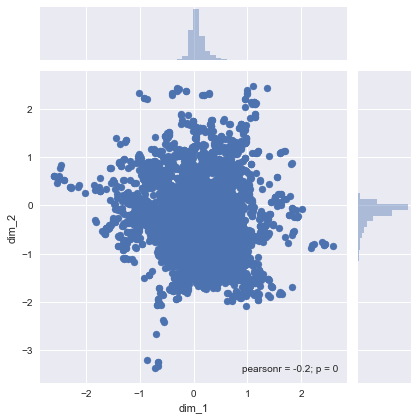

In [6]:
hist.plot_scatter(dim=[[0, 1]])

In [7]:
history = hist.get("chain")[0]
N = len(history)
start_from = 0

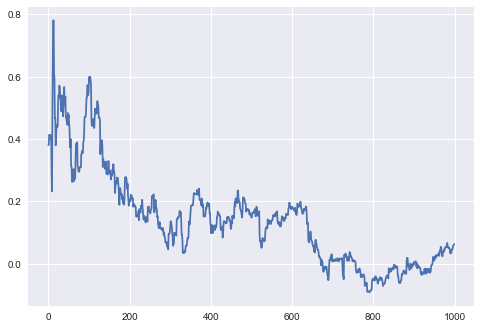

In [8]:
plt.plot(np.arange(N - start_from), history[start_from:, 0])

In [9]:
hist.acceptance_rate

0.95133000000000001